# init

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

# imports
import glob, os, re
import pandas as pd
import numpy as np
from IPython.display import display, display_html
%config IPCompleter.greedy=True
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",200)
%matplotlib inline
def display_side_by_side(list):
    html_str=''
    for df in list:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


In [2]:
# load files
def files_to_df(file_mask):
    path = r'./data/' # use your path
    all_files = glob.glob(os.path.join(path, file_mask))
    return pd.concat((pd.read_csv(f, header=0, sep=';') for f in all_files))

df_apt = files_to_df('DataViz*_APT.csv')
df_emi = files_to_df('DataViz*_EMI_*.csv')
df_ret = files_to_df('DataViz*_RET_*.csv')
df_tra = files_to_df('DataViz*_TRA_*.csv')

# DFs

In [3]:
display(df_apt.head(1), df_apt.shape)
display(df_emi.head(1), df_emi.shape)
display(df_ret.head(1), df_ret.shape)
display(df_tra.head(1), df_tra.shape)

,APT_OACI,APT_IATA,APT_NOM,APT_ISO2,APT_PAYS,PAYS_ZON,PAYS_FSC,APT_LAT,APT_LONG
0,LFMH,EBU,ST-ETIENNE-LOIRE,FR,France (Métrop.),M,CC,"45,53","4,30"


(1511, 9)

,ANMOIS,APT,FSC,ZON,CAT,MVT,PAX,PEQ,CO2,NOX,COVNM,TSP
0,200901,LFPG,LC,I,A,1,2,2,"0,001","0,001","0,000","0,000"


(26898, 12)

,ANMOIS,DEP,ARR,PC15_D,PC15_A,RETARD_D,RETARD_A
0,201209,LEBL,LFSB,NaN,"0,101",NaN,"4,7"


(187375, 7)

,ANMOIS,DEP,ARR,NVOLS,PAX_FS,FSC,ZON
0,199801,BKPR,LFSB,19,2720,MC,I


(1014552, 7)

# create JSON for pollution emissions per aeroport

### Create DF with delays (ret) per month

In [4]:
# remove null values
df_ret1 = df_ret.fillna(value='0').copy()

# set values as numeric
df_ret1[['PC15_D','PC15_A','RETARD_D','RETARD_A']] = (
    df_ret1[['PC15_D','PC15_A','RETARD_D','RETARD_A']]
    .astype('str')
    .applymap(lambda val: val.replace(',','.'))
    .apply(pd.to_numeric)
)

# get average delay per apt
df_ret_permonth = df_ret1.groupby(['DEP','ANMOIS'])['RETARD_D'].agg('mean').reset_index()

display_side_by_side([df_ret.head(2),df_ret_permonth.head(2)])

ANMOIS 
 DEP 
 ARR 
 PC15_D 
 PC15_A 
 RETARD_D 
 RETARD_A 
 
 
 
 
 0 
 201209 
 LEBL 
 LFSB 
 NaN 
 0,101 
 NaN 
 4,7 
 
 
 1 
 201209 
 LEBL 
 LFLL 
 NaN 
 0,087 
 NaN 
 5,0 
 
 
 
 
 
 
 DEP 
 ANMOIS 
 RETARD_D 
 
 
 
 
 0 
 BIKF 
 201201 
 0.0 
 
 
 1 
 BIKF 
 201202 
 0.0

### Create DF with emissions per month

In [5]:
# remove null values
df_emi1 = df_emi.fillna(value='0').copy()
# set values as numeric
df_emi1[['CO2','NOX','COVNM','TSP']] = df_emi1[
    ['CO2','NOX','COVNM','TSP']
].applymap(lambda val: val.replace(',','.')).apply(pd.to_numeric)
# get average delay per apt
df_emi_permonth = df_emi1.groupby(['APT','ANMOIS'])[['CO2','NOX','COVNM','TSP']].agg('sum').reset_index()

display_side_by_side([df_emi.head(2),df_emi_permonth.head(2)])

ANMOIS 
 APT 
 FSC 
 ZON 
 CAT 
 MVT 
 PAX 
 PEQ 
 CO2 
 NOX 
 COVNM 
 TSP 
 
 
 
 
 0 
 200901 
 LFPG 
 LC 
 I 
 A 
 1 
 2 
 2 
 0,001 
 0,001 
 0,000 
 0,000 
 
 
 1 
 200901 
 LFPG 
 LC 
 I 
 B 
 379 
 30462 
 31019 
 0,537 
 2,251 
 0,324 
 0,085 
 
 
 
 
 
 
 APT 
 ANMOIS 
 CO2 
 NOX 
 COVNM 
 TSP 
 
 
 
 
 0 
 LFBD 
 200001 
 2.421 
 9.580 
 1.295 
 0.384 
 
 
 1 
 LFBD 
 200002 
 2.316 
 9.172 
 1.113 
 0.367

## Add in out pax ratio

In [39]:
df_tra_edit = df_tra.copy()

df_tra_edit['PAX_FS_OUT'] = df_tra_edit['PAX_FS']
df_tra_edit['PAX_FS_IN'] = df_tra_edit['PAX_FS']

df_paxOut = df_tra_edit.loc[:,['ANMOIS','DEP','PAX_FS_OUT']]
df_paxIn = df_tra_edit.loc[:,['ANMOIS','ARR','PAX_FS_IN']]
df_paxOut = df_paxOut.rename(columns = {"DEP": "APT"})
df_paxIn = df_paxIn.rename(columns = {"ARR": "APT"})

df_pax_mvt = df_paxOut.append(df_paxIn).fillna(0)
#df_pax_mvt['YEAR'] = df_pax_mvt['ANMOIS'].fillna(0).apply(lambda val: val//100).astype(int).astype(str)

df_pax_mvt_gb = df_pax_mvt.groupby(['ANMOIS','APT'])[['PAX_FS_IN','PAX_FS_OUT']].agg('sum').reset_index()
df_pax_mvt_gb['PAX_RATIO'] = (df_pax_mvt_gb['PAX_FS_IN']/(df_pax_mvt_gb['PAX_FS_IN']+df_pax_mvt_gb['PAX_FS_OUT']))
df_pax_mvt_gb.tail()
# df_pax_mvt_gb.fillna(0).describe()

,ANMOIS,APT,PAX_FS_IN,PAX_FS_OUT,PAX_RATIO
107485,201803,ZPPP,1673.0,1928.0,0.464593
107486,201803,ZSPD,37937.0,38917.0,0.493624
107487,201803,ZUUU,2527.0,3248.0,0.437576
107488,201803,ZZM_,82208.0,81579.0,0.501920
107489,201803,ZZO_,1195.0,1407.0,0.459262


### Join with apts

In [51]:
# join delays with apts
df_ret_emi = pd.merge(df_emi_permonth, df_ret_permonth,
                        how='outer', left_on=['APT','ANMOIS'],right_on=['DEP','ANMOIS']
                       ).drop_duplicates().fillna(0)
df_ret_emi = df_ret_emi[df_ret_emi.APT == df_ret_emi.DEP]
df_ret_emi = df_ret_emi.dropna(subset=['APT','DEP'])

df_apt_clean0 = pd.merge(
    df_ret_emi, 
    df_pax_mvt_gb.loc[:,['ANMOIS','APT','PAX_RATIO']], 
    how='outer', on=['APT','ANMOIS']
)

df_apt_clean1 = pd.merge(df_apt_clean0, df_apt, how='outer', left_on='APT', right_on='APT_OACI')

# split year and month
df_apt_clean2 = df_apt_clean1.copy()
df_apt_clean2['YEAR'] = df_apt_clean2['ANMOIS'].fillna(0).apply(lambda val: val//100).astype(int)#.astype(str)
df_apt_clean2['MONTH'] = df_apt_clean2['ANMOIS'].fillna(0).apply(lambda val: val%100).astype(int).astype(str)
# set values as numeric
df_apt_clean2[['APT_LAT','APT_LONG']] = (
    df_apt_clean2[['APT_LAT','APT_LONG']]
    .fillna('0')
    .applymap(lambda val: val.replace(',','.'))
    .apply(pd.to_numeric))

df_apt_clean2['APT'] = df_apt_clean2['APT_OACI']
df_apt_clean2['YEAR'] = df_apt_clean2['YEAR'].fillna('null')
df_apt_clean2['ANMOIS'] = df_apt_clean2['ANMOIS'].fillna(0).astype(int).astype(str)
df_apt_clean3 = (df_apt_clean2
                 .drop(columns=['DEP','APT_OACI','APT_IATA','APT_ISO2','PAYS_ZON','PAYS_FSC'])
                 .drop_duplicates()
                 .fillna(0))
# df_apt_clean3 = df_apt_clean3[df_apt_clean3.ANMOIS != '0']

df_apt_clean = df_apt_clean3[df_apt_clean3.YEAR > 1999].copy()

display(df_apt_clean.shape, df_apt_clean[df_apt_clean.RETARD_D > 0].head(3))

(73942, 14)

,APT,ANMOIS,CO2,NOX,COVNM,TSP,RETARD_D,PAX_RATIO,APT_NOM,APT_PAYS,APT_LAT,APT_LONG,YEAR,MONTH
0,LFBD,201201,2.932,13.106,0.860,0.465,10.292000,0.490092,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,1
2,LFBD,201202,2.793,12.570,0.790,0.444,13.008333,0.481242,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,2
4,LFBD,201203,3.262,14.708,0.922,0.517,8.576923,0.517088,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,3


# create dict grouped by APT, YEAR

In [57]:
interesting_values = ['CO2','NOX','COVNM','TSP','RETARD_D','PAX_RATIO']
def populate_emi_json_per_year(row, dct, vals):
    empty_dict = {}
    for val in vals:
        empty_dict[val] = {'val': 0,'color':0,'monthly':{
            '1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,'11':0,'12':0}}
    # fill global data
    if dct.get(row['APT']) is None:
        dct[row['APT']] = {
            'APT': row['APT'],'APT_NOM': row['APT_NOM'], 'APT_PAYS': row['APT_PAYS'], 
            'APT_LAT': row['APT_LAT'], 'APT_LONG': row['APT_LONG'], 'data': {}}
    # fill by year
    if row['YEAR']is not 'null':
        if dct[row['APT']]['data'].get(row['YEAR']) is None:
            dct[row['APT']]['data'][row['YEAR']] = empty_dict
        # get value
        for val in vals:
            if (val == 'PAX_RATIO'):
                dct[row['APT']]['data'][row['YEAR']][val]['val'] += row[val]/12
                try:
                    dct[row['APT']]['data'][row['YEAR']][val]['monthly'][row['MONTH']] += row[val]
                except KeyError:
                    display(row)
            else:
                dct[row['APT']]['data'][row['YEAR']][val]['val'] += row[val]
                try:
                    dct[row['APT']]['data'][row['YEAR']][val]['monthly'][row['MONTH']] += row[val]
                except KeyError:
                    display(row)

# create dict from df
dict_per_year = {}
a = df_apt_clean.apply(populate_emi_json_per_year, axis=1, args=(dict_per_year,interesting_values))
display(df_apt_clean.head(10),len(dict_per_year))

,APT,ANMOIS,CO2,NOX,COVNM,TSP,RETARD_D,PAX_RATIO,APT_NOM,APT_PAYS,APT_LAT,APT_LONG,YEAR,MONTH
0,LFBD,201201,2.932,13.106,0.860,0.465,10.292000,0.490092,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,1
2,LFBD,201202,2.793,12.570,0.790,0.444,13.008333,0.481242,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,2
4,LFBD,201203,3.262,14.708,0.922,0.517,8.576923,0.517088,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,3
6,LFBD,201204,3.223,14.394,0.901,0.512,18.654839,0.492000,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,4
8,LFBD,201205,3.481,15.612,1.011,0.553,9.469697,0.505219,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,5
10,LFBD,201206,3.658,16.316,1.018,0.580,11.888235,0.506224,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,6
12,LFBD,201207,3.725,16.739,1.024,0.590,13.107895,0.495208,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,7
14,LFBD,201208,3.529,15.858,0.943,0.560,13.835135,0.497584,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,8
16,LFBD,201209,3.629,16.101,0.977,0.576,16.668571,0.504509,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,9
18,LFBD,201210,3.589,15.852,0.949,0.570,15.415152,0.486246,BORDEAUX-MERIGNAC,France (Métrop.),44.83,-0.72,2012,10


665

### Add color index based on percentile

In [58]:
def fill_colors(dct, years, vals):
    yt,ot,rt = 0,0,0
    # get data samples
    for year in years:
        for val in vals:
            tmp_val = []
            for key, row in dct.items():
                try:
                    tmp_val.append(row['data'][year][val]['val'])
                except KeyError:
                    tmp_val.append(0)
            # get mean etc
            a = np.array(tmp_val)
            a = a[a != 0]
            if a.size > 0:
                yt = np.percentile(a, 40) # yellow threshold
                ot = np.percentile(a, 70) # orange threshold
                rt = np.percentile(a, 90) # red threshold
                # fill the color
                for key, row in dct.items():
                    try:
                        dct[key]['data'][year][val]['color'] = get_color(yt,ot,rt, row['data'][year][val]['val'])
                    except KeyError:
                        pass
def get_color(yt,ot,rt,val):
    if (val > rt): return 4
    if (val > ot): return 3
    if (val > yt): return 2
    if (val > 0): return 1
    return 0

# fill colors (based on percentile)
fill_colors(dict_per_year, df_apt_clean.YEAR.unique().tolist(),interesting_values)
# display(len(dict_emi_per_year), dict_emi_per_year)

### Turn dict into list of apts

In [59]:
apts = []
for apt_key, apt_data in dict_per_year.items():
    apts.append(apt_data)
    
display(len(apts))

665

# Save json

In [60]:
import json

with open('./data/data.json', 'w') as fp:
    json.dump(apts, fp, ensure_ascii=False)

# study delays

In [11]:
display(df_ret.shape, df_ret.head(2))

(187375, 7)

,ANMOIS,DEP,ARR,PC15_D,PC15_A,RETARD_D,RETARD_A
0,201209,LEBL,LFSB,NaN,"0,101",NaN,"4,7"
1,201209,LEBL,LFLL,NaN,"0,087",NaN,"5,0"


In [0]:
# remove null values
df_ret = df_ret.fillna(value='0')

# set values as numeric
df_ret[['PC15_D','PC15_A','RETARD_D','RETARD_A']] = df_ret[
    ['PC15_D','PC15_A','RETARD_D','RETARD_A']
].applymap(lambda val: val.replace(',','.')).apply(pd.to_numeric)

# split year and month
df_ret['YEAR'] = df_ret['ANMOIS'].apply(lambda val: val//100)
df_ret['MONTH'] = df_ret['ANMOIS'].apply(lambda val: val%100)

# add airport names (human readable)
apt_names = {}
for row in df_apt[['APT_OACI','APT_NOM']].itertuples():
    apt_names[str(row[1])] = row[2]

df_ret['DEP_NAME'] = df_ret['DEP'].map(apt_names)
df_ret['ARR_NAME'] = df_ret['ARR'].map(apt_names)

In [13]:
df_ret_year = df_ret.groupby(['DEP','YEAR','MONTH'])['RETARD_D'].agg('mean').reset_index().set_index('DEP')

display(df_ret_year.shape, df_ret_year[df_ret_year['RETARD_D'] > 0].head(3))

(21336, 3)

,YEAR,MONTH,RETARD_D
DEP,,,
FMCZ,2016,8,9.7
FMCZ,2017,5,0.2
FMCZ,2017,6,7.2


In [14]:
weirdos = df_ret[(df_ret['PC15_A'] == 0) & (df_ret['PC15_D'] == 0)]
display(weirdos.head(3))
print(len(weirdos.index))
retards = df_ret[(df_ret['RETARD_D'] > df_ret['RETARD_A']) & (df_ret['RETARD_A'] > 0)]
display(retards.head(3))
print(len(retards.index))

,ANMOIS,DEP,ARR,PC15_D,PC15_A,RETARD_D,RETARD_A,YEAR,MONTH,DEP_NAME,ARR_NAME
4,201209,LEBL,LFST,0.0,0.0,0.0,2.9,2012,9,BARCELONE-EL PRAT,STRASBOURG-ENTZHEIM
28,201209,LFSB,LPPT,0.0,0.0,0.8,0.0,2012,9,BALE-MULHOUSE,LISBONNE-UMBERTO DELGADO
45,201209,LFSB,LEAL,0.0,0.0,1.0,0.0,2012,9,BALE-MULHOUSE,ALICANTE


8155


,ANMOIS,DEP,ARR,PC15_D,PC15_A,RETARD_D,RETARD_A,YEAR,MONTH,DEP_NAME,ARR_NAME
15,201209,LFSB,LFLL,0.071,0.095,4.6,4.2,2012,9,BALE-MULHOUSE,LYON-ST-EXUPERY
18,201209,LFSB,LFMN,0.188,0.125,8.0,7.6,2012,9,BALE-MULHOUSE,NICE-COTE D'AZUR
19,201209,LFSB,LFPG,0.087,0.096,4.2,3.9,2012,9,BALE-MULHOUSE,PARIS-CHARLES DE GAULLE


18413


In [91]:
df_ret_per_apt = df_ret.groupby(['DEP']).agg({'RETARD_D' : ['mean', 'median'], 'RETARD_A' : ['mean', 'median']})

tmp = df_ret_per_apt[df_ret_per_apt['RETARD_D']['mean'] > 0]
print('retard_d mean   > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_D']['median'] > 0]
print('retard_d median > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_A']['mean'] > 0]
print('retard_a mean   > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_A']['median'] > 0]
print('retard_a median > 0:',len(tmp.index))

retard_d mean   > 0: 53
retard_d median > 0: 46
retard_a mean   > 0: 378
retard_a median > 0: 363


In [92]:
df_ret_per_apt = df_ret.groupby(['DEP', 'ANMOIS']).agg({'RETARD_D' : ['mean', 'median'], 'RETARD_A' : ['mean', 'median']})

tmp = df_ret_per_apt[df_ret_per_apt['RETARD_D']['mean'] > 0]
print('retard_d mean   > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_D']['median'] > 0]
print('retard_d median > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_A']['mean'] > 0]
print('retard_a mean   > 0:',len(tmp.index))
tmp = df_ret_per_apt[df_ret_per_apt['RETARD_A']['median'] > 0]
print('retard_a median > 0:',len(tmp.index))

retard_d mean   > 0: 2743
retard_d median > 0: 2733
retard_a mean   > 0: 20995
retard_a median > 0: 20023


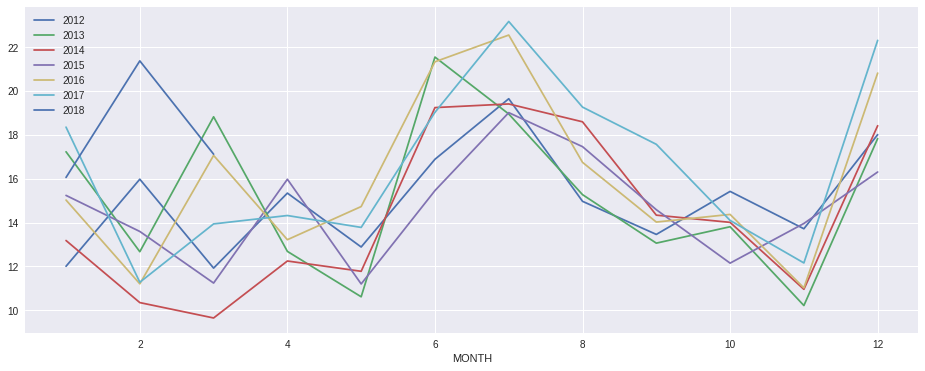

,YEAR,MONTH,RETARD_D
0,2012,1,12.007692
1,2012,2,15.974742
2,2012,3,11.923737


In [39]:
df_ret_paris_per_month = (
    df_ret[df_ret['DEP'] == 'LFPG']
    .groupby(['YEAR','MONTH'])
    .agg({'RETARD_D':'mean'})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(16, 6))

for key, grp in df_ret_paris_per_month.groupby('YEAR'):
    ax = grp.plot.line(ax=ax, label=key, x='MONTH',y='RETARD_D')

plt.show()